In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [2]:
FILEPATH='data/block_2010_data/nhgis0005_csv'
relevant_cols = ['GISJOIN', 'STATEA', 'COUNTYA', 'H7X001', 'H7X002', 'H7X003', 'H7X004', 
                               'H7X005', 'H7X006', 'H7X007', 'H7X008']
race_raw = pd.read_csv(f'{FILEPATH}/nhgis0005_ds172_2010_block.csv', 
                       usecols=relevant_cols, 
                       dtype={'GISJOIN': str, 'STATEA': str, 'COUNTYA': str})
column_mapper = dict(zip(relevant_cols, ['GISJOIN', 'state_fips', 'county_fips', 'total', 'white',
                                        'black', 'american_indian_al_native', 'asian', 
                                        'hawaiian_pac_islander', 'other', 'two_plus']))
race_raw.rename(columns=column_mapper, inplace=True)
print("Race data loaded.")
race_raw.set_index('GISJOIN', inplace=True)
race_raw

Race data loaded.


state_fips county_fips  total  white  black  \
GISJOIN                                                          
G06000104001001000         06         001      0      0      0   
G06000104001001001         06         001      0      0      0   
G06000104001001002         06         001      0      0      0   
G06000104001001003         06         001      0      0      0   
G06000104001001004         06         001      0      0      0   
...                       ...         ...    ...    ...    ...   
G42013300240022033         42         133     19     18      0   
G42013300240022034         42         133     48     48      0   
G42013300240022035         42         133     16     16      0   
G42013300240022036         42         133     44     35      2   
G42013300240022037         42         133     19     19      0   

                    american_indian_al_native  asian  hawaiian_pac_islander  \
GISJOIN                                                                       
G06000104001001000                          0      0                      0   
G06000104001001001                          0      0                      0   
G06000104001001002                          0      0                      0   
G06000104001001003                          0      0                      0   
G06000104001001004                          0      0                      0   
...                                       ...    ...                    ...   
G42013300240022033                          0      0                      0   
G42013300240022034                          0      0                      0   
G42013300240022035                          0      0                      0   
G42013300240022036                          0      0                      0   
G42013300240022037                          0      0                      0   

                    other  two_plus  
GISJOIN                              
G06000104001001000      0         0  
G06000104001001001      0         0  
G06000104001001002      0         0  
G06000104001001003      0         0  
G06000104001001004      0         0  
...                   ...       ...  
G42013300240022033      0         1  
G42013300240022034      0         0  
G42013300240022035      0         0  
G42013300240022036      0         7  
G42013300240022037      0         0  

[2699631 rows x 10 columns]

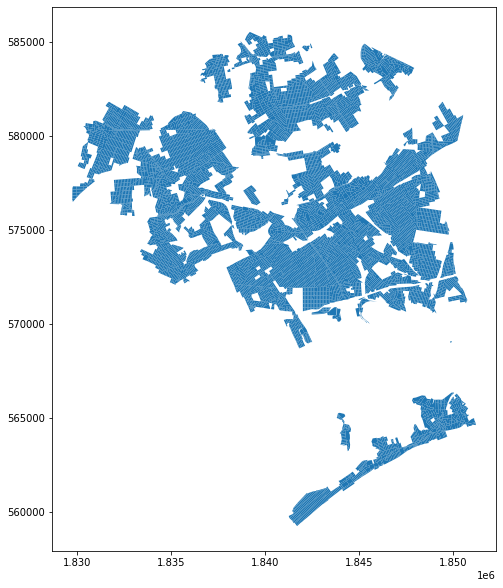

In [9]:
queens_blocks = gpd.read_file(
    'data/block_2010_data/nhgis0005_shape/nhgis0005_shapefile_tl2010_360_block_2010/NY_block_2010.shp').set_index('GEOID10')
queens_rl_cw = pd.read_csv('data/outputs/Queens_blocks_2010_crosswalk.csv', dtype={'block_id_2010': str}).set_index('block_id_2010')
queens_blocks = queens_blocks.join(queens_rl_cw, how='outer').dropna().set_index('GISJOIN')
queens_blocks.plot(figsize=(10,10))


In [10]:
queens = queens_blocks.join(race_raw, how='outer').dropna()

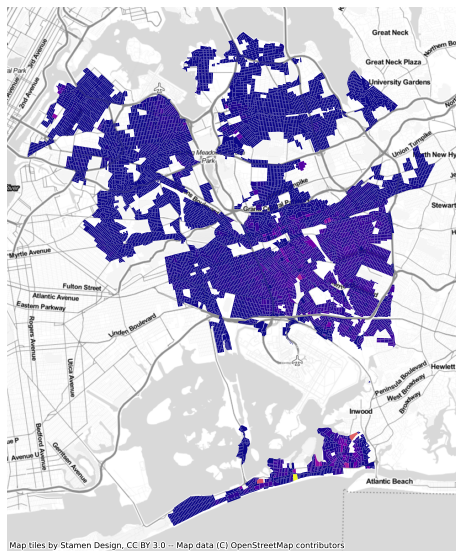

In [11]:
import contextily as ctx
def plot_map(df, column, figsize=(10,10), cmap='plasma'):
    ax = df.to_crs(epsg=3857).plot(figsize=figsize, cmap=cmap, column=column)
    ax.set_axis_off()
    ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

plot_map(queens, 'black')

In [12]:
R = queens.groupby('holc_id_uq').sum().filter(['total', 'white', 'black', \
    'american_indian_al_native', 'asian', 'hawaiian_pac_islander', \
    'hawaiian_pac_islander', 'other', 'two_plus'])

In [13]:
R

total  white  black  american_indian_al_native  asian  \
holc_id_uq                                                          
A0           5810   3907    116                          3   1499   
B1          13364   5538    250                         71   5384   
B10         30270  15912    830                        231   4342   
B11          7834   4768    252                         26   2045   
B12          4564   2796     34                          5   1542   
...           ...    ...    ...                        ...    ...   
D160        11559   3948    305                        200   1626   
D161         1107    157    324                          2    511   
D164         3646    694    458                         10   2001   
D165         2333   1509     20                          0    647   
D167          652     32    550                          0      6   

            hawaiian_pac_islander  hawaiian_pac_islander  other  two_plus  
holc_id_uq                                                                 
A0                              1                      1    121       163  
B1                              2                      2   1549       570  
B10                            17                     17   7314      1624  
B11                             6                      6    490       247  
B12                             0                      0     69       118  
...                           ...                    ...    ...       ...  
D160                            2                      2   4761       717  
D161                            0                      0     78        35  
D164                            7                      7    335       141  
D165                            0                      0    114        43  
D167                            0                      0     30        34  

[163 rows x 9 columns]

In [14]:
def city_entropy(R, P):
    """
    Computes entropy of a city-region (see White, 1986).

    Parameters
    ----------
    R : numpy.ndarray
        i-by-j matrix, where i=districts and j=ethnicities.
    P : numpy.array
        i-length vector of the total population in a city-region.
    
    Returns
    -------
    int
        citywide segregation entropy score.
    """
    # define key terms in algorithm
    N = sum(P)
    i, j = R.shape
    R_prop = np.nan_to_num(np.apply_along_axis(lambda column: column / P, 0, R))
    r_hat = R.sum(axis=0) / N

    
    def entropy(x):
        """compute an entropy score with region ethnicity proportion vector x."""
        with np.errstate(divide='ignore'):
            vec = np.log(x)
        vec[np.isneginf(vec)] = 0 # fix special case where 0 * ln(0) = 0
        return (-1) * sum(x*vec)
    
    # compute district-level entropy scores
    h_i = list(map(entropy, R_prop))

    # compute city-wide entropy
    H_hat = entropy(r_hat)
    H_bar = sum((P/N) * h_i)
    
    return (H_hat - H_bar) / H_hat


In [15]:
def chain_to_entropy(chainobj, blocks):
    """
    Takes element in Markov Chain and computes entropy score using the partition map.
    Parameters
    ----------
    chainobj : gerrychain.partition.partition.Partition
        Partition object that dictates which elements belong to which partitions.
    blocks : geopandas.GeoDataFrame
        Dataframe containing the map's census blocks and associated race information.
    
    Returns
    -------
    int
        entropy score using the partition data from Markov Chain element.
    """
    # use partition parts and grouping to create R and P
    R = blocks.drop(columns=['geometry']).copy()
    R['partition'] = blocks.index.map(dict(chainobj.assignment))
    R = R.groupby('partition').sum()
    R, P = R.to_numpy()[:, 1:], R.to_numpy()[:, 0]

    return city_entropy(R, P)

In [16]:
race_matrix = queens.filter(['total', 'white', 'black', 'american_indian_al_native', 'asian', 'hawaiian_pac_islander', 'other', 'two_plus', 'holc_id_uq', 'geometry'])
race_matrix.rename(columns={'holc_id_uq': 'partition'}, inplace=True)
race_matrix

total  white  black  american_indian_al_native  asian  \
GISJOIN                                                                     
G36008100002001000    280    148     26                          4     25   
G36008100002001001    290    116     37                          4     24   
G36008100002001002    253     80      5                          0     70   
G36008100002001003    207     75     42                          0     49   
G36008100002002000    572    256     52                         10    114   
...                   ...    ...    ...                        ...    ...   
G36008101621005010     54     18      2                          0     17   
G36008101621005011     67     11     13                          0     15   
G36008101621005012    168     50     26                          0     53   
G36008101621005013    117     32     13                          0     24   
G36008101621005014     27     10      8                          0      8   

                    hawaiian_pac_islander  other  two_plus partition  \
GISJOIN                                                                
G36008100002001000                      0     63        14       C77   
G36008100002001001                      0     82        27       C77   
G36008100002001002                      0     90         8       C77   
G36008100002001003                      0     21        20       C77   
G36008100002002000                      0    109        31       C77   
...                                   ...    ...       ...       ...   
G36008101621005010                      0     11         6       C88   
G36008101621005011                      0     28         0       C88   
G36008101621005012                      0     28        11       C88   
G36008101621005013                      0     41         7       C88   
G36008101621005014                      0      1         0       C88   

                                                             geometry  
GISJOIN                                                                
G36008100002001000  POLYGON ((1838319.997 573100.148, 1838147.550 ...  
G36008100002001001  POLYGON ((1838355.913 573031.891, 1838183.228 ...  
G36008100002001002  POLYGON ((1838392.001 572964.366, 1838332.071 ...  
G36008100002001003  POLYGON ((1838476.648 572805.798, 1838431.319 ...  
G36008100002002000  POLYGON ((1838147.550 573006.176, 1838183.228 ...  
...                                                               ...  
G36008101621005010  POLYGON ((1848805.940 578924.221, 1848781.775 ...  
G36008101621005011  POLYGON ((1848722.597 578910.770, 1848655.722 ...  
G36008101621005012  POLYGON ((1848683.571 578980.443, 1848616.697 ...  
G36008101621005013  POLYGON ((1848655.722 578872.351, 1848546.169 ...  
G36008101621005014  POLYGON ((1848745.389 578870.499, 1848734.428 ...  

[10253 rows x 10 columns]

In [17]:
def compute_total_pop(partition):
    global race_matrix
    R = race_matrix.drop(columns=['geometry']).copy()
    R['partition'] = race_matrix.index.map(dict(partition.assignment))
    return R.groupby('partition').sum()['total'].to_dict()

In [18]:
from gerrychain import (GeographicPartition, Partition, Graph, MarkovChain, proposals, updaters, constraints, accept)
from gerrychain.updaters import Tally
from gerrychain.proposals import recom, propose_chunk_flip, propose_random_flip
from gerrychain.constraints import districts_within_tolerance, no_vanishing_districts, WithinPercentRangeOfBounds
from gerrychain.accept import always_accept
from functools import partial
from tqdm.notebook import tqdm
import networkx as nx

graph = Graph.from_geodataframe(race_matrix, adjacency='queen')

(1828692.2318012025, 1852286.4777704387, 557943.9743025609, 586828.8616938267)

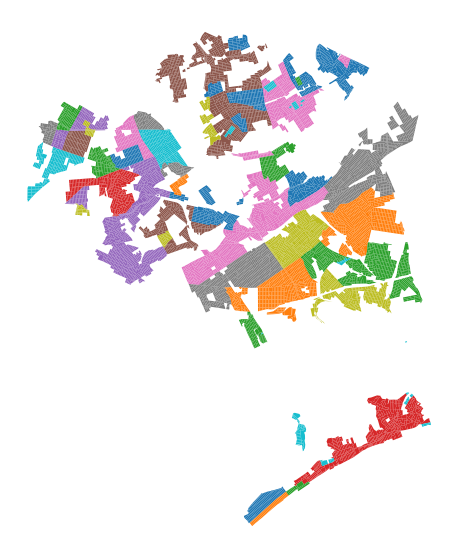

In [19]:
nx.set_node_attributes(graph, race_matrix['total'].to_dict(), name='population')
init_partition = Partition(graph, 
                    assignment=race_matrix.to_dict()['partition'],
                    updaters={'population' : Tally('population')})
init_partition.plot(figsize=(10,10))
plt.axis('off')

0

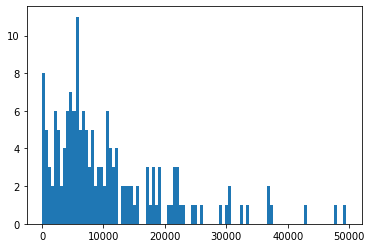

In [20]:
import seaborn as sns
plt.hist(list(init_partition['population'].values()), bins=100)
np.percentile(list(init_partition['population'].values()), [2.5, 97.5])
min(list(init_partition['population'].values()))

In [25]:
ideal_population = sum(compute_total_pop(init_partition).values()) / len(init_partition)
from gerrychain.constraints import Validator, LowerBound
mean_pop = lambda part: np.mean(list(part['population'].values()))
min_pop = lambda part: min(list(part['population'].values()))
is_valid = Validator([WithinPercentRangeOfBounds(mean_pop, 25), LowerBound(min_pop, 0)])
BURN_IN = 1000
STEP_COUNT = 10000 + BURN_IN
proposal = partial(recom, 
                    pop_col='population', 
                    pop_target=ideal_population,
                    epsilon=100,
                    node_repeats=20000000)
chain = MarkovChain(proposal=propose_chunk_flip, 
                    constraints=is_valid,
                    accept=always_accept, 
                    initial_state=init_partition, 
                    total_steps=STEP_COUNT)
print('Prereqs created, chain running...')
# burn-in of 1000
iter(chain)
print("Burn-in:")
_ = [next(chain) for i in tqdm(range(BURN_IN))]
entropies = [chain_to_entropy(next(chain), race_matrix) for i in tqdm(range(STEP_COUNT - BURN_IN))]
chain = None
# np.save("results/arrays/queens_cf_100000.npy", entropies)

Prereqs created, chain running...
Burn-in:


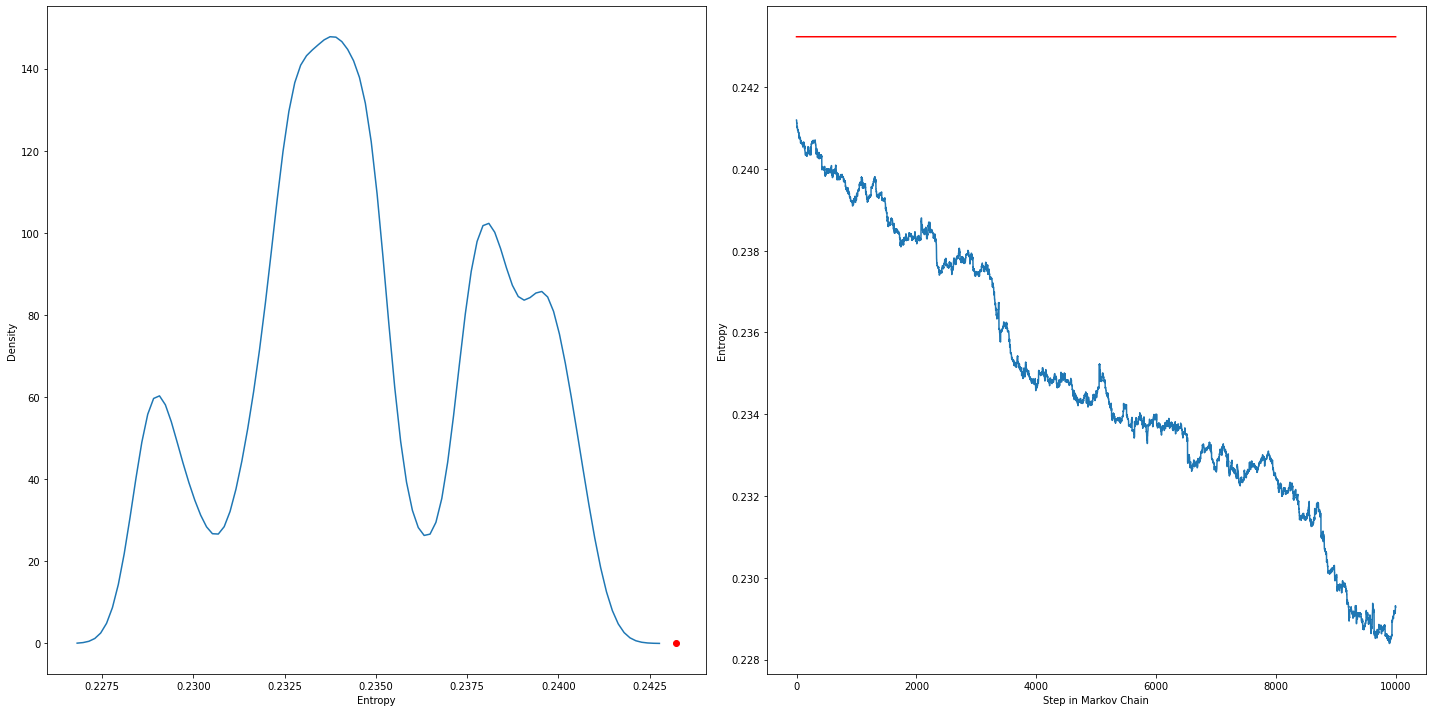

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.xlabel("Entropy")
plt.ylabel("Density")
sns.kdeplot(entropies)
plt.scatter(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), 0, c='r')

plt.subplot(1, 2, 2)
plt.xlabel("Step in Markov Chain")
plt.ylabel("Entropy")
plt.plot(np.arange(STEP_COUNT - 1000), entropies)
plt.plot(np.arange(STEP_COUNT - 1000), np.repeat(city_entropy(R.to_numpy()[:, 1:], R.to_numpy()[:, 0]), STEP_COUNT - 1000), c='r')

plt.tight_layout()
# plt.savefig("results/plots/queens_cf_100000.png")